In [31]:
import pandas as pd
import numpy as np
import datetime
#from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import pyfolio as pf
from finrl.plot import backtest_plot
from sklearn.svm import SVC

In [32]:
ZTS = pd.read_csv("phase3_data/zts.csv")
ZTS = ZTS.loc[:, 'Report Date': 's_diff']
ZTS['Report Date'] = pd.to_datetime(ZTS['Report Date'])
all_date_column = ZTS['Report Date']

In [33]:
ZTS['Return'] = ZTS['Stock price'].pct_change()
ZTS['Stock price'] = ZTS['Stock price'].shift(-1)
ZTS['Y_boolean'] = ZTS['Y_boolean'].shift(-1)
ZTS['Return'] = ZTS['Return'].shift(-1)
ZTS = ZTS.dropna()

In [34]:
# function to select data given date window
def window(start, end, df, all_date_column):
    '''
    Given a start and end date, return df with data only
    from that period
    
    Inputs:
        start/end: start and end dates
            ex: start = '2022-01-23' ('YYYY-MM-DD')
        df: pd dataframe
        date: pd series with dates of all possible dates in data
    
    Returns: pd dataframe
    '''

    date_column = all_date_column[all_date_column.between(start, end, inclusive='both')]
    df = pd.concat([date_column, df], axis = 1, join="inner")
    df = df.iloc[:, 1:]

    return df

In [35]:
def feature_selection_FS(training_dataset, testing_dataset, bar):
    """
    find the important feature using Fishers' score
    """

    X = training_dataset.iloc[:, 3:-1]
    Y_price = training_dataset['Stock price']
    Y_dummy = training_dataset['Y_boolean']
    date_train = training_dataset['Report Date']
    date_test = testing_dataset['Report Date']

    ranks = fisher_score.fisher_score(X.to_numpy(), Y_dummy)
    feat_importances = pd.Series(ranks, training_dataset.columns[3:-1])
#     feat_importances.plot(kind='barh', color ="teal")
#     plt.show()
    
    feat_selected = feat_importances.to_frame('importance')
    # select importance > than bar
    feat_selected = feat_selected[feat_selected['importance'] > bar]
    select_feature_lst = ['Report Date', 'Stock price', 'Y_boolean'] + list(feat_selected.index)
    
    return training_dataset[select_feature_lst], testing_dataset[select_feature_lst]
    
    
    

In [36]:
def feature_selection_IG(training_dataset, testing_dataset, bar):
    """
    find the important feature using IG method
    """

    X = training_dataset.iloc[:, 3:-1]
    Y_price = training_dataset['Stock price']
    Y_dummy = training_dataset['Y_boolean']
    date_train = training_dataset['Report Date']
    date_test = testing_dataset['Report Date']
    importances = mutual_info_classif(X, Y_dummy, random_state=1241)
    feat_importances = pd.Series(importances, training_dataset.columns[3:-1])
#     feat_importances.plot(kind='barh', color ="teal")
#     plt.show()

    feat_selected = feat_importances.to_frame('importance')
    # select importance > than bar
    feat_selected = feat_selected[feat_selected['importance'] > bar]
    select_feature_lst = ['Report Date', 'Stock price', 'Y_boolean'] + list(feat_selected.index)
    
    return training_dataset[select_feature_lst], testing_dataset[select_feature_lst]
    

In [37]:
def test_feature_select(training_dataset, validate_dataset):
    """
    check the performance of the current selected: use only training dataset accuracy 
    """
    # run baseline logit
    logit = LogisticRegression(solver = 'lbfgs', random_state=1241)
    X = training_dataset.iloc[:, 3:-1]
    Y_dummy = training_dataset['Y_boolean']
    logit.fit(X, Y_dummy)
    Y_dummy_validate = validate_dataset['Y_boolean']
    X_validate = validate_dataset.iloc[:, 3:-1]
    Y_pred = logit.predict(X_validate)
    # pred = lr.predict(testing_dataset)
#     score = logit.score(testing_dataset, Y_true)
    
    score = accuracy_score(Y_dummy_validate, Y_pred)
    return score

In [8]:
# collect all date
date_starts = []
date = datetime.datetime(2020, 3, 2)
date_starts.append(date)

for idx in range(660):#range(722):
    date += datetime.timedelta(days=1)
    date_starts.append(date)
    


In [9]:
features_selected = []

for train_date_start in date_starts:
    print(train_date_start)
    train_date_end = train_date_start + datetime.timedelta(days=90)
    validate_date_start = train_date_end + datetime.timedelta(days=1)
    validate_date_end = validate_date_start + datetime.timedelta(days=30)
    test_date_start = validate_date_end + datetime.timedelta(days=1)
    test_date_end = test_date_start

    train_data = window(train_date_start, train_date_end, ZTS, all_date_column)
    validate_data = window(validate_date_start, validate_date_end, ZTS, all_date_column)
    test_data = window(test_date_start, test_date_end, ZTS, all_date_column)

    bars_FS = range(0, 11)
    bars_IG = np.arange(0, 0.03, 0.005)#np.arange(0, 0.1005, 0.005)
 
    best_accuracy = 0
    best_bar = []
    best_features = []
    
    for bar_FS in bars_FS:
        for bar_IG in bars_IG:
            
            try:
                train_ZTS_selected, validate_ZTS_selected = feature_selection_FS(train_data, validate_data, bar_FS)
                train_ZTS_selected, validate_ZTS_selected = feature_selection_IG(train_ZTS_selected, validate_ZTS_selected, bar_IG)
                score = test_feature_select(train_ZTS_selected, validate_ZTS_selected)
                if score > best_accuracy:
                    best_accuracy = score
                    best_bar = [bar_FS, bar_IG]
                    best_features = train_ZTS_selected.iloc[:,3:].columns
            except:
                continue
    features_selected.append(best_features)

2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:00:00
2020-03-05 00:00:00
2020-03-06 00:00:00
2020-03-07 00:00:00
2020-03-08 00:00:00
2020-03-09 00:00:00
2020-03-10 00:00:00
2020-03-11 00:00:00
2020-03-12 00:00:00
2020-03-13 00:00:00
2020-03-14 00:00:00
2020-03-15 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-21 00:00:00
2020-03-22 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-28 00:00:00
2020-03-29 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00
2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-04 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-10 00:00:00
2020-04-11 00:00:00
2020-04-12 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00
2020-04-17 00:00:00
2020-04-18 00:00:00
2020-04-19 00:00:00
2020-04-20 00:00:00


2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-15 00:00:00
2021-05-16 00:00:00
2021-05-17 00:00:00
2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00
2021-05-21 00:00:00
2021-05-22 00:00:00
2021-05-23 00:00:00
2021-05-24 00:00:00
2021-05-25 00:00:00
2021-05-26 00:00:00
2021-05-27 00:00:00
2021-05-28 00:00:00
2021-05-29 00:00:00
2021-05-30 00:00:00
2021-05-31 00:00:00
2021-06-01 00:00:00
2021-06-02 00:00:00
2021-06-03 00:00:00
2021-06-04 00:00:00


In [10]:
list(features_selected[0])

['Debt Ratio',
 'R&D / Revenue',
 'Return on Research Capital',
 'tweet_subjectivity',
 'RSI_ratio',
 'MACD']

In [11]:
features_selected[0]

Index(['Debt Ratio', 'R&D / Revenue', 'Return on Research Capital',
       'tweet_subjectivity', 'RSI_ratio', 'MACD'],
      dtype='object')

In [38]:
import pickle

In [39]:
with open('ZTS features', 'wb') as f:
    pickle.dump(features_selected, f)

In [40]:
with open('ZTS features', 'rb') as f:
    features_selected = pickle.load(f)

In [15]:
models = {'random forest': RandomForestClassifier(random_state=0,
                            n_jobs=-1,
                            n_estimators=10,
                            class_weight='balanced'),
          'logistic regression': LogisticRegression(max_iter=1000,
                                                    penalty='l2',
                                                    tol=0.001,
                                                    solver='newton-cg'),
          'SVC': SVC(kernel='poly'),
          'KNN': KNeighborsClassifier(n_neighbors=5),
          'gradient boosting':GradientBoostingClassifier(max_depth= 10, random_state=0, n_estimators=10)
         }

In [16]:
results = {}
for model_name, model in models.items():
    if model_name not in results:
        dates = []
        predictions = []
        truth = []
        returns = []
        for train_date_start, features in zip(date_starts, features_selected):
            train_date_end = train_date_start + datetime.timedelta(days=90)
            validate_date_start = train_date_end + datetime.timedelta(days=1)
            validate_date_end = validate_date_start + datetime.timedelta(days=30)
            test_date_start = validate_date_end + datetime.timedelta(days=1)
            test_date_end = test_date_start

            train_data = window(train_date_start, train_date_end, ZTS, all_date_column)
            validate_data = window(validate_date_start, validate_date_end, ZTS, all_date_column)
            test_data = window(test_date_start, test_date_end, ZTS, all_date_column)

            train = pd.concat([train_data, validate_data])

            model.fit(train[features], train['Y_boolean'])
            predictions.append(model.predict(test_data[features])[0])
            dates.append(test_data['Report Date'].values[0])
            truth.append(test_data['Y_boolean'].values[0])
            returns.append(test_data['Return'].values[0])
        results[model_name] = pd.DataFrame({'date':dates, 
                                            'prediction': predictions,
                                            'truth': truth,
                                            'returns': returns})
        results[model_name]['portfolio returns'] = results[model_name]['returns'] * results[model_name]['prediction']
        results[model_name]['portfolio cumulative returns'] = np.cumprod(1 + results[model_name]['portfolio returns'])


In [17]:
for model_name in results.keys():
    acc = sum(results[model_name]['prediction'] == results[model_name]['truth']) / len(results[model_name])
    print(f'{model_name} score:{round(acc,3)}')

random forest score:0.383
logistic regression score:0.363
SVC score:0.366
KNN score:0.369
gradient boosting score:0.36


In [18]:
def backtest(df):
    df_account_value = df[['date', 'portfolio cumulative returns']]
    df_account_value.columns = ['date', 'account_value']
    backtest_plot(df_account_value, 
              baseline_ticker='SPY',
              baseline_start = df_account_value.date.iloc[0],
              baseline_end = df_account_value.date.iloc[-1])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (456, 8)


Start date,2020-07-02
End date,2022-04-23
Total months,31
,Backtest
Annual return,-1.707%
Cumulative returns,-4.415%
Annual volatility,14.661%
Sharpe ratio,-0.04
Calmar ratio,-0.05
Stability,0.47
Max drawdown,-37.385%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.38,2020-11-22,2021-12-28,NaT,NaN
1,5.74,2020-09-25,2020-10-12,2020-10-28,24
2,4.86,2020-08-05,2020-08-13,2020-09-24,37
3,3.70,2020-07-05,2020-07-28,2020-08-01,20
4,1.98,2020-11-03,2020-11-04,2020-11-18,12


Stress Events,mean,min,max
New Normal,-0.00%,-4.52%,6.87%


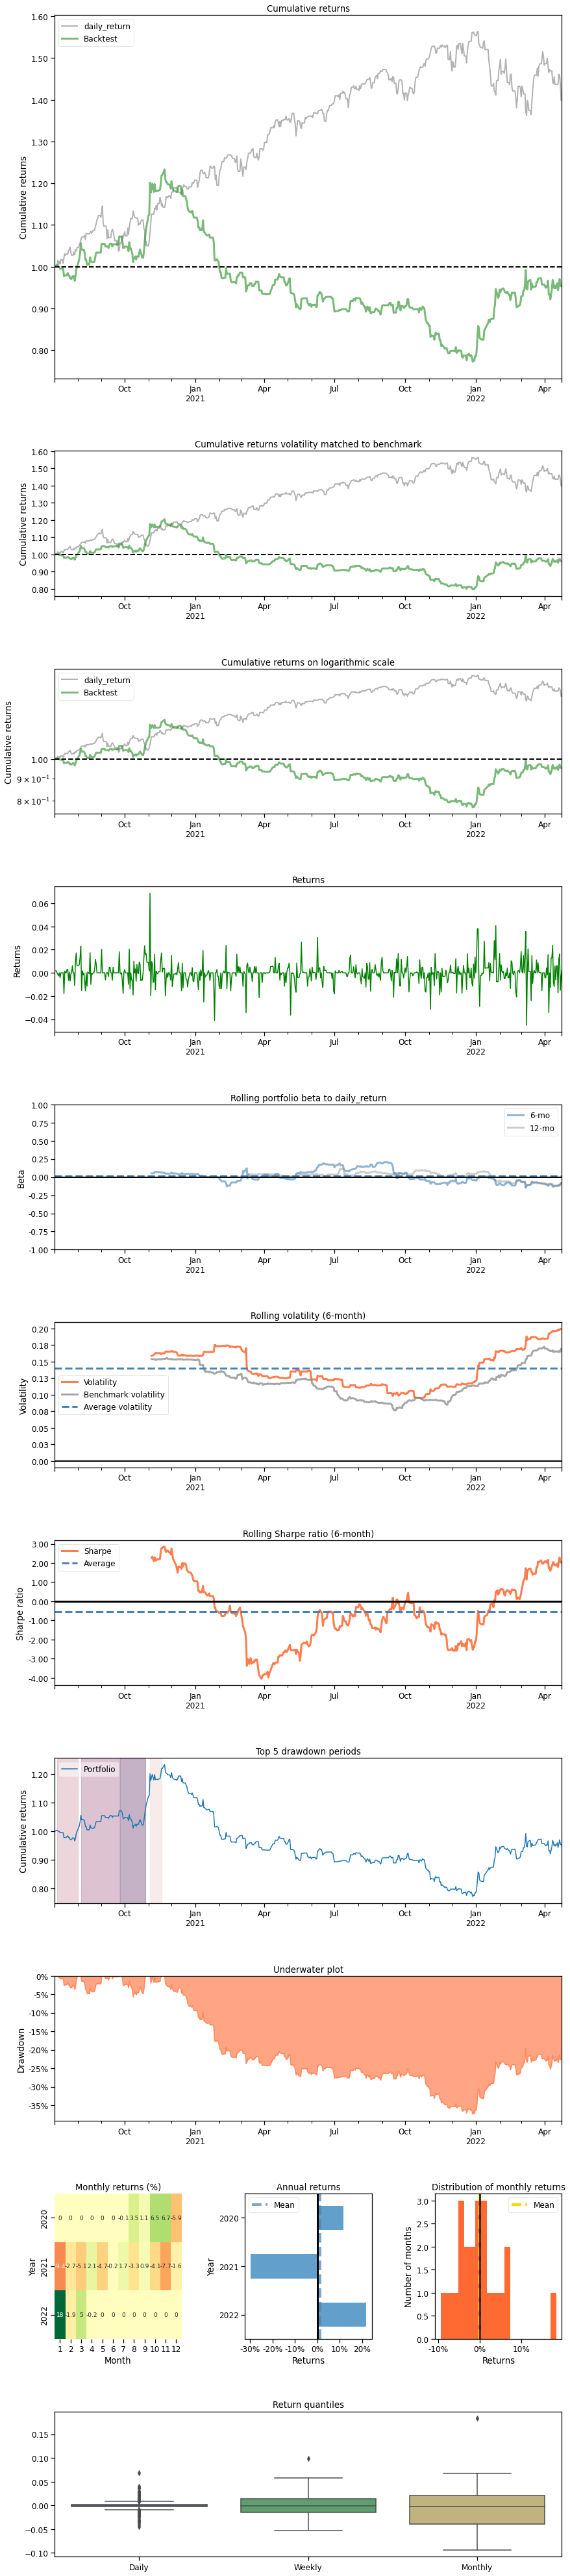

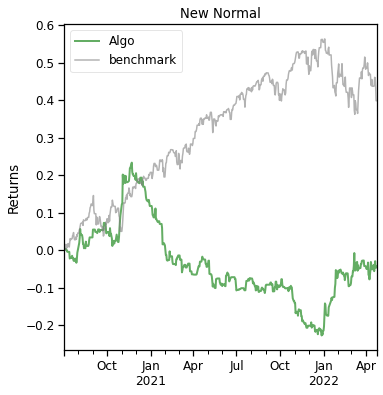

In [19]:
backtest(results['gradient boosting'])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (456, 8)


Start date,2020-07-02
End date,2022-04-23
Total months,31
,Backtest
Annual return,8.331%
Cumulative returns,23.354%
Annual volatility,14.951%
Sharpe ratio,0.61
Calmar ratio,0.35
Stability,0.01
Max drawdown,-23.556%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.56,2020-11-22,2021-12-29,2022-03-07,336
1,7.59,2022-03-30,2022-04-09,NaT,NaN
2,7.01,2020-11-01,2020-11-03,2020-11-20,15
3,4.68,2020-09-05,2020-09-08,2020-10-01,19
4,4.19,2020-08-05,2020-08-24,2020-09-02,21


Stress Events,mean,min,max
New Normal,0.04%,-6.87%,4.92%


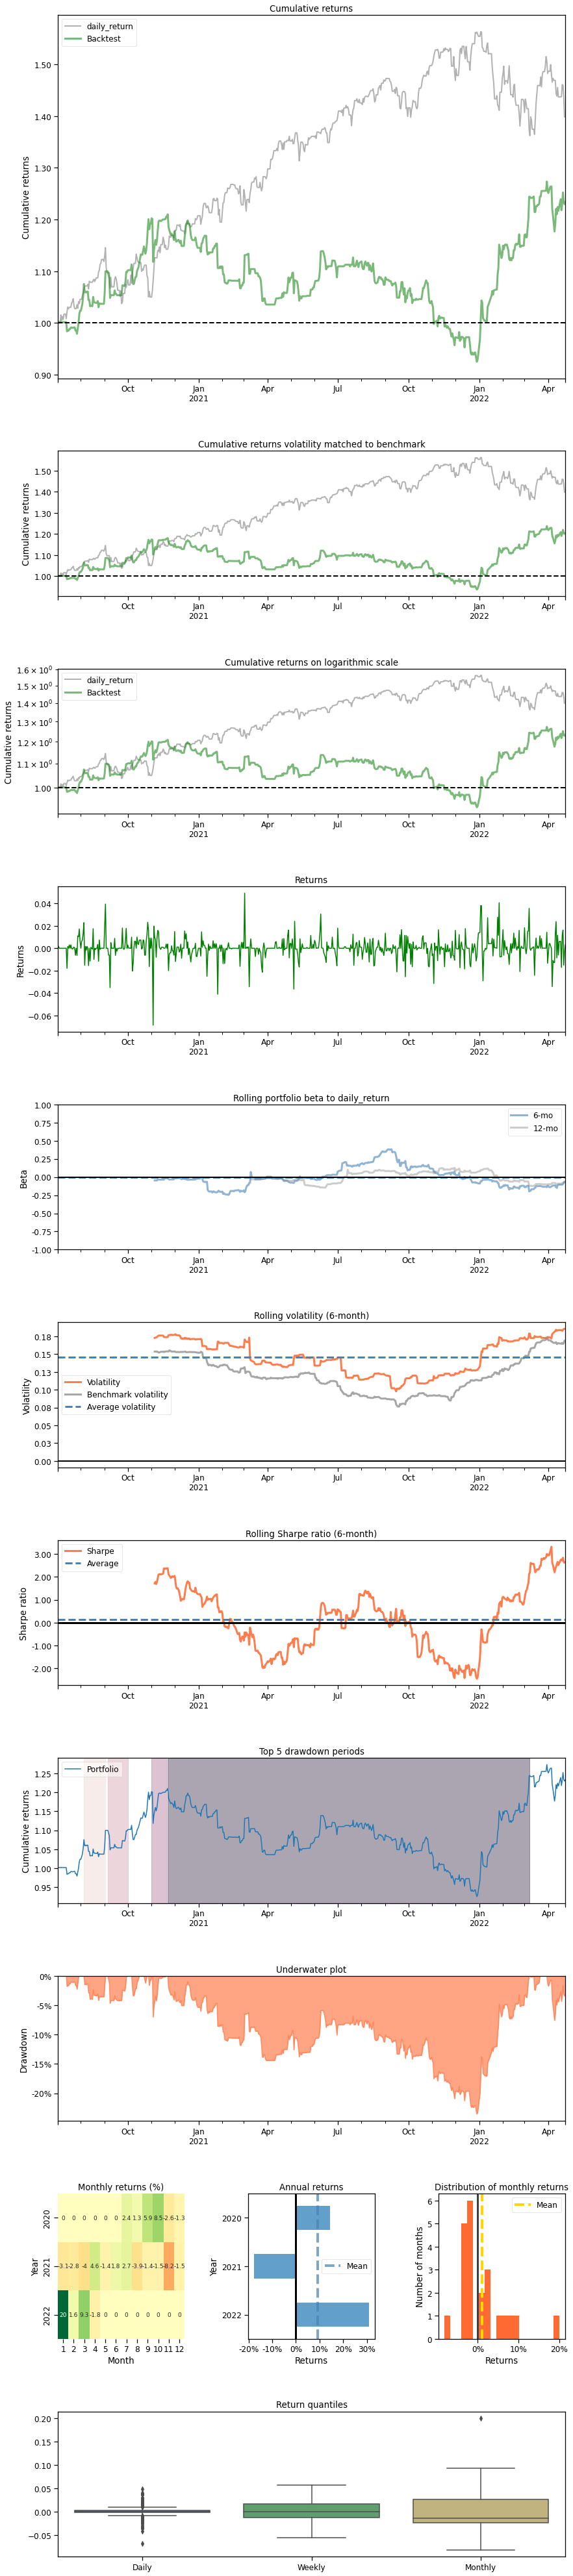

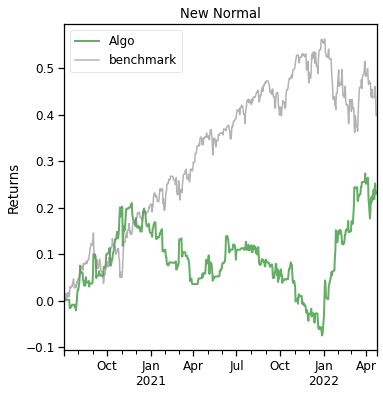

In [20]:
backtest(results['random forest'])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (456, 8)


Start date,2020-07-02
End date,2022-04-23
Total months,31
,Backtest
Annual return,21.302%
Cumulative returns,65.953%
Annual volatility,13.797%
Sharpe ratio,1.47
Calmar ratio,1.70
Stability,0.77
Max drawdown,-12.508%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.51,2022-03-07,2022-04-09,NaT,NaN
1,10.19,2021-07-28,2021-10-26,2021-12-24,108
2,7.44,2022-01-26,2022-02-08,2022-03-07,29
3,6.60,2020-12-02,2021-05-05,2021-06-03,132
4,5.03,2020-10-11,2020-10-17,2020-11-03,17


Stress Events,mean,min,max
New Normal,0.08%,-4.52%,6.87%


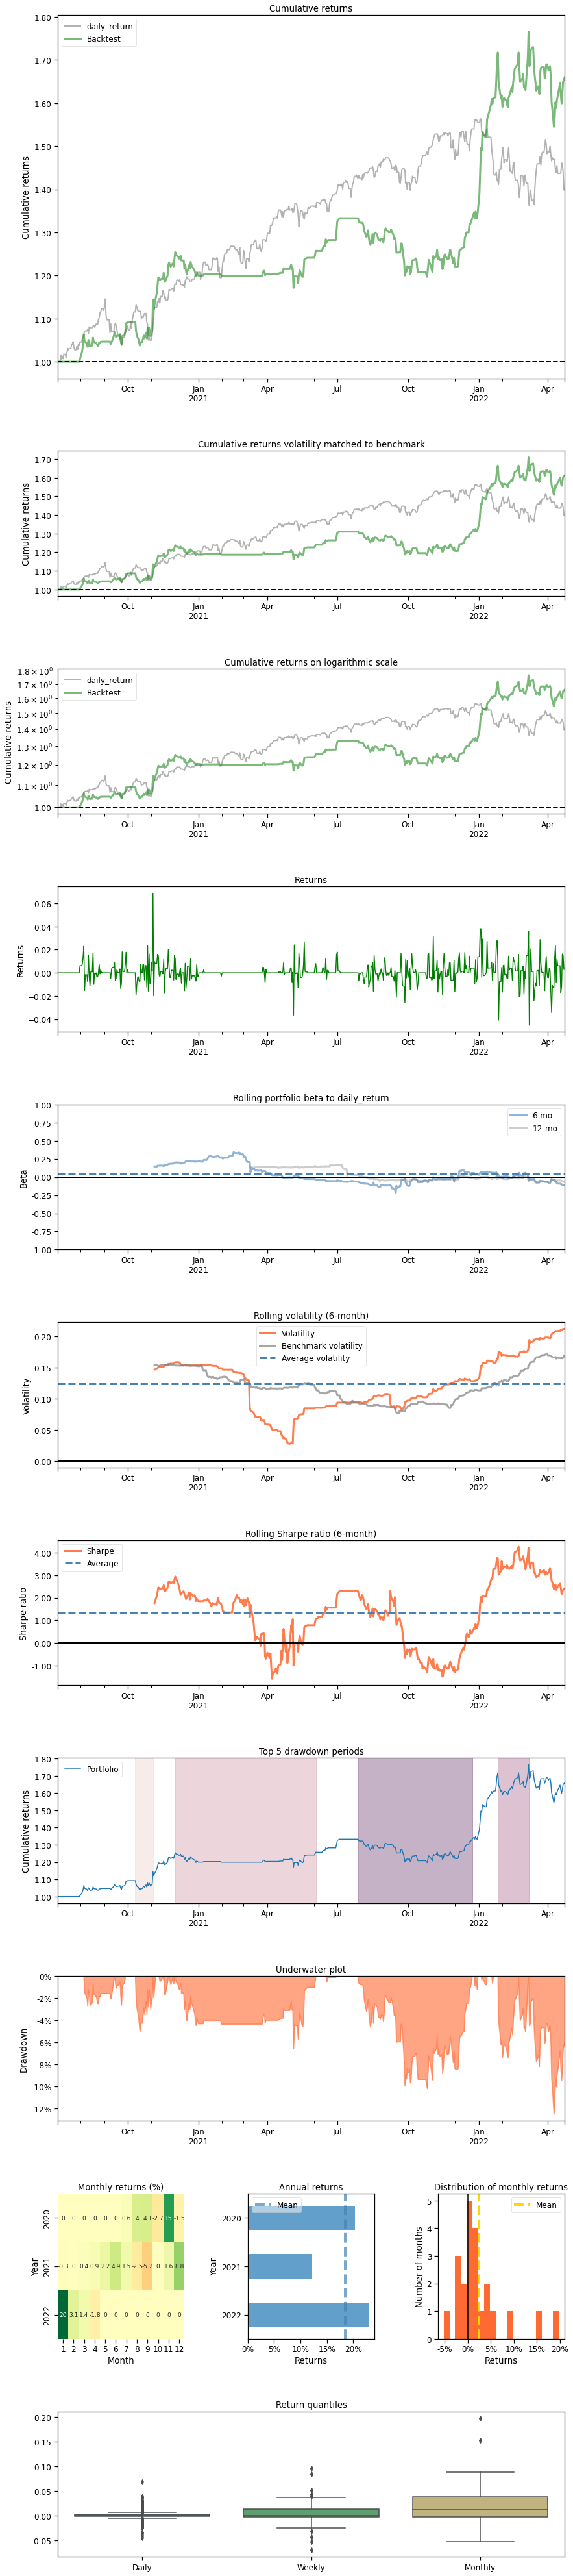

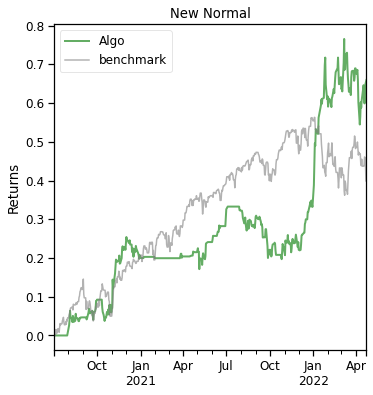

In [21]:
backtest(results['logistic regression'])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (456, 8)


Start date,2020-07-02
End date,2022-04-23
Total months,31
,Backtest
Annual return,23.696%
Cumulative returns,74.683%
Annual volatility,13.89%
Sharpe ratio,1.60
Calmar ratio,1.97
Stability,0.78
Max drawdown,-12.032%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.03,2022-03-07,2022-04-09,NaT,NaN
1,9.26,2021-07-28,2021-10-06,2021-12-21,105
2,7.46,2020-12-02,2021-05-05,2021-06-30,151
3,7.44,2022-01-26,2022-02-08,2022-03-07,29
4,4.33,2020-10-11,2020-10-16,2020-10-27,12


Stress Events,mean,min,max
New Normal,0.09%,-4.52%,6.87%


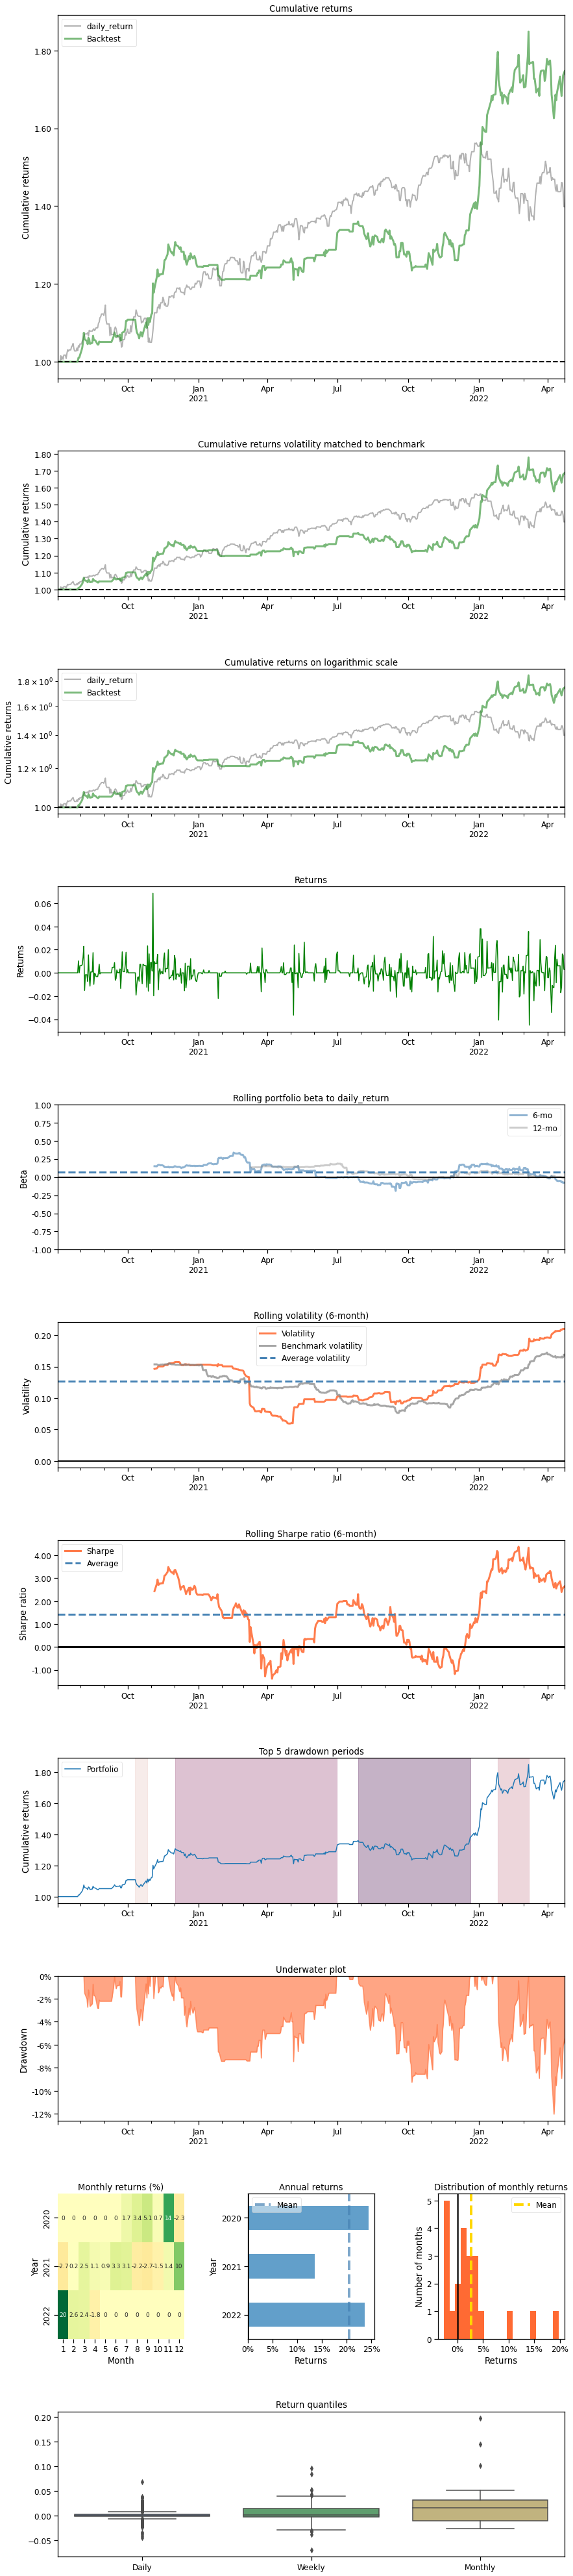

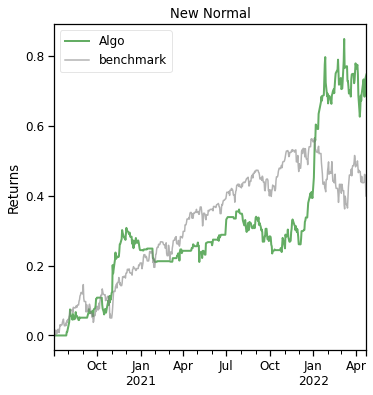

In [22]:
backtest(results['SVC'])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (456, 8)


Start date,2020-07-02
End date,2022-04-23
Total months,31
,Backtest
Annual return,4.547%
Cumulative returns,12.371%
Annual volatility,14.628%
Sharpe ratio,0.38
Calmar ratio,0.29
Stability,0.40
Max drawdown,-15.729%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.73,2020-11-22,2021-02-11,2021-03-10,78
1,14.31,2020-08-05,2020-10-12,2020-11-17,75
2,12.63,2022-01-26,2022-04-13,NaT,NaN
3,12.34,2021-04-20,2021-07-14,2021-11-09,146
4,12.22,2021-11-15,2021-12-29,2022-01-06,39


Stress Events,mean,min,max
New Normal,0.02%,-4.11%,4.92%


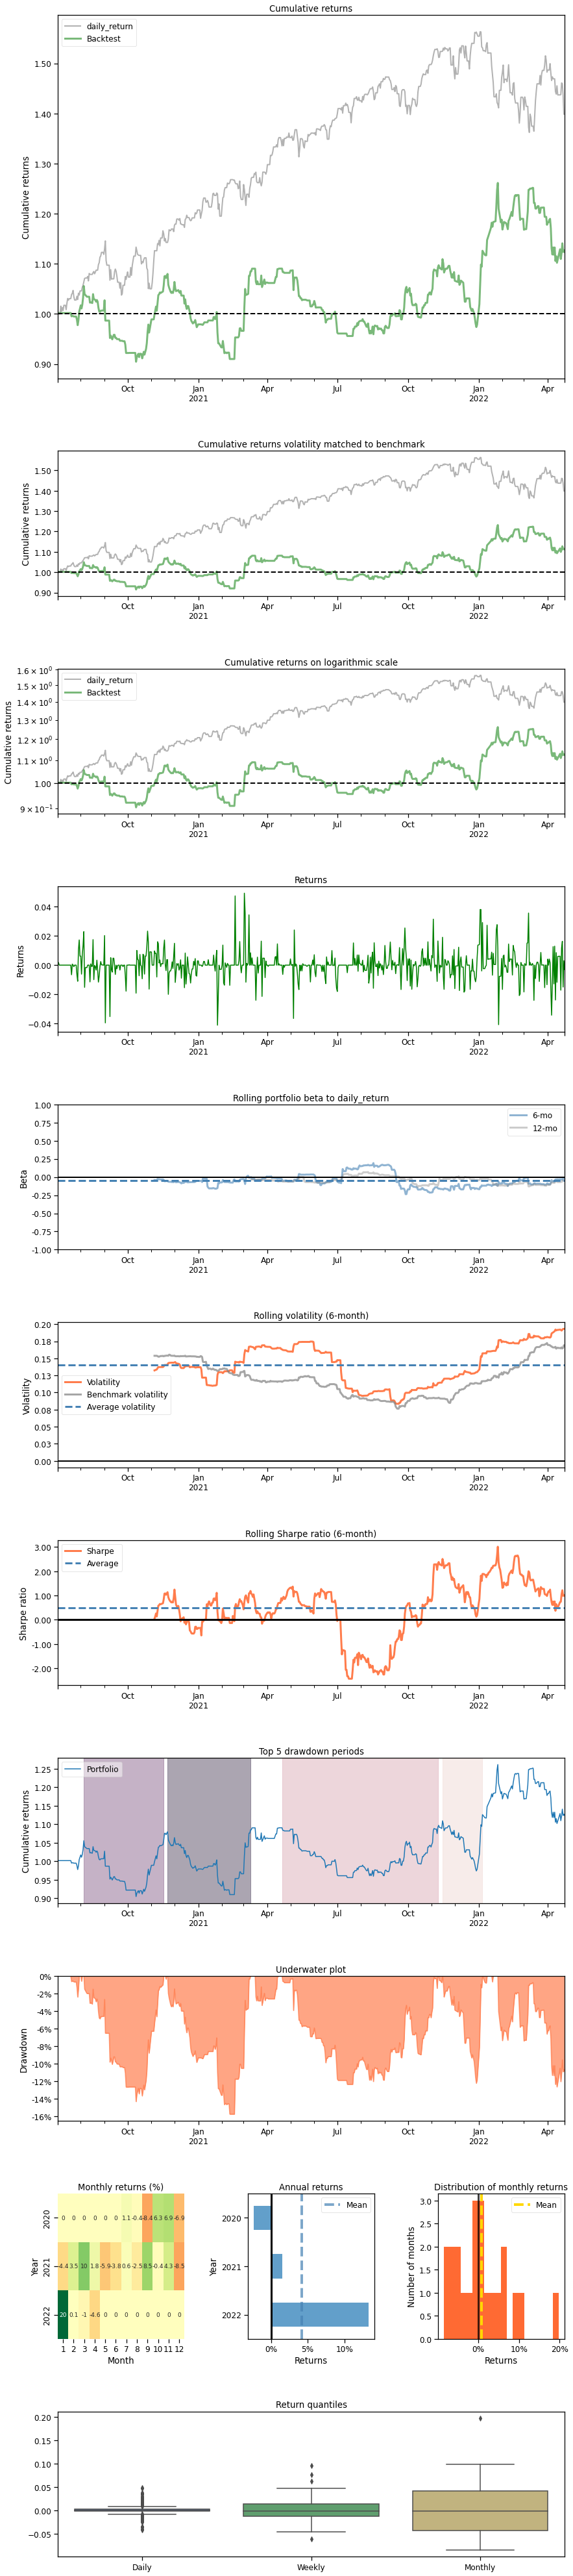

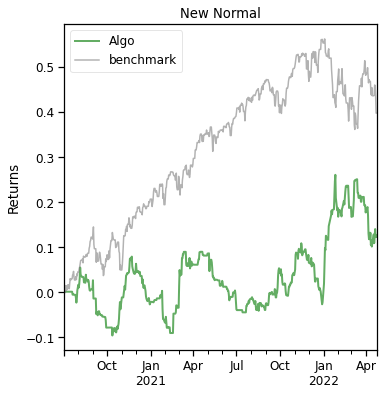

In [23]:
backtest(results['KNN'])